In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from myMLlib import set_seed, plt_confusion, plt_loss, BIMHSAttention #multi_SA_memwise
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix,  roc_curve, roc_auc_score
import torch
from torch import optim, nn
# from torch.utils.data import random_split, TensorDataset, DataLoader
import yaml
import os
from numpy.lib.stride_tricks import sliding_window_view
from tqdm.notebook import tqdm  # Import tqdm for progress bar

In [2]:
with open('hyperparameters.yml', 'r') as file:
    all_parameters = yaml.safe_load(file)
    parameters = all_parameters["The_third_NeedleARM"]
materials = parameters["materials"]
realmater = parameters["realmater"]
dir_path = parameters["dir_path"]
materials = list(materials.values())
print(materials)
print(realmater)

['Vessel', 'Tissue']
['Silicone/Water', 'Silicone']


In [3]:
class Wor():
    def __init__(self,i = None):
        self.a = {0:"_mv",1:""}
        self.i = 0 if i is None else i
        self.data = self.a[self.i]
    def move(self):
        self.i+=1
        if self.i >= 2:
            self.i = 0
        self.data = self.a[self.i]
        return self


In [4]:
name = "/home/yuqster/files/research/dataset/realtest_mwt8/loop-0_Tissue_position-1-18depth_mv.npy"
a = np.load(name)
print(a.shape)

(2, 4096, 1)


In [5]:
seedl = 42
set_seed(seedl)
two_label_depth = []
folderpath = [os.path.join(dir_path,x) for x in ("realtest_mwt9","realtest_mwt10")]
two_data = []
folderloops =  (100, 100)
two_labels = []
for loopnum,folder in zip(folderloops,folderpath):
    data = []
    label_depth = []
    label = []
    for y, mater in enumerate(materials):
        for loop in range(loopnum):
            for position in range(6):
                mv = Wor(1)
                channel = []
                depth_l = []
                for depth in range(16,21):
                    while True:
                        filename = f"loop-{loop}_{mater}_position-{position}-{depth}depth{mv.data}.npy"
                        filepath = os.path.join(folder,filename)
                        signals = np.load(filepath)
                        channel.append(signals)
                        depth_l.append(np.repeat(depth-16, repeats=signals.shape[0]))
                        mv.move()
                        if mv.i == 0: 
                            break
                data.append(np.concatenate(channel,axis=0))
                label.append(y)
                label_depth.append(np.concatenate(depth_l))
    two_data.append(data)
    two_labels.append(label)
    two_label_depth.append(label_depth)


1200
(59, 4096, 1)


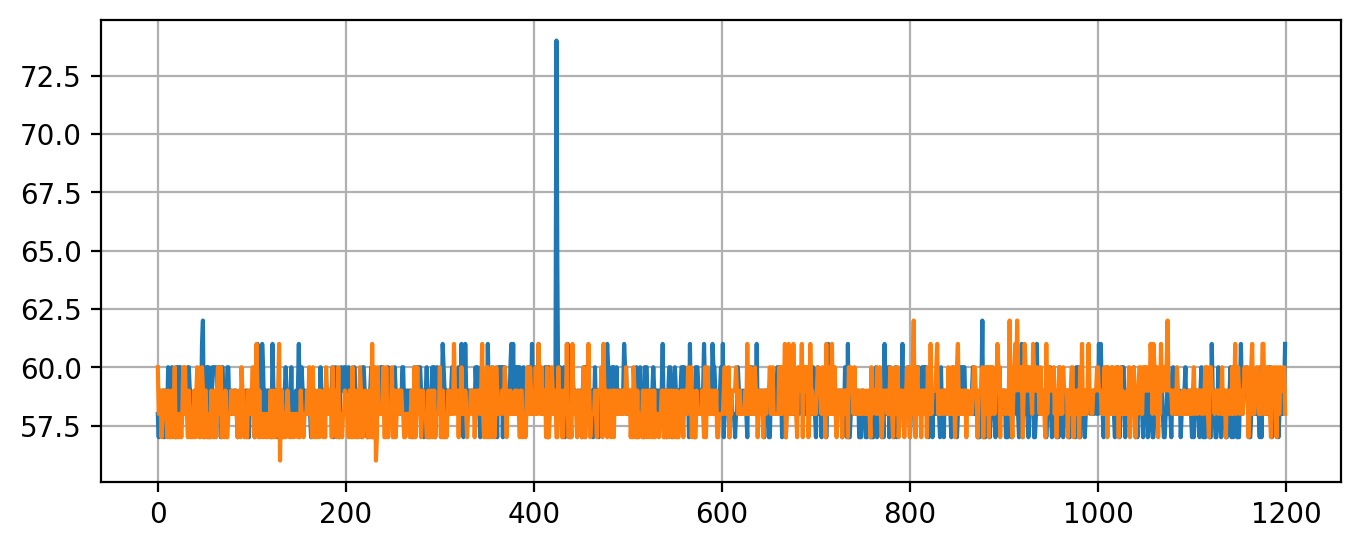

In [6]:
print(len(two_data[0]))
print(two_data[0][2].shape)
plt.figure(dpi=200,figsize=(8,3))
two_shapes = []
for dataset in two_data:
    shapes = []
    for data in dataset:
        shapes.append(data.shape[0])
    plt.plot(shapes)
    two_shapes.append(shapes)
plt.grid()

In [7]:
idx = {"train":list(range(0,400)) + list(range(600,1000)), "test":list(range(400,600)) + list(range(1000,1200))}
mater_idx = {"V":list(range(400)) + list(range(800,1200)), "T":list(range(400, 800)) + list(range(1200,1600))}
print(idx["train"])
print(idx["test"])
print(mater_idx["V"])
print(mater_idx["T"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [8]:

shapelist = [two_shapes[i][j] for i in range(2) for j in idx["train"]]
shape_test = [two_shapes[i][j] for i in range(2) for j in idx["test"]]

datalist = [two_data[i][j] for i in range(2) for j in idx["train"]]
data_test = [two_data[i][j] for i in range(2) for j in idx["test"]]

depthlist = [two_label_depth[i][j] for i in range(2) for j in idx["train"]]
depthtest = [two_label_depth[i][j] for i in range(2) for j in idx["test"]]

labellist =  [two_labels[i][j] for i in range(2) for j in idx["train"]]
label_test = [two_labels[i][j] for i in range(2) for j in idx["test"]]

print(len(shapelist))
print(len(shape_test))

print(len(labellist))
print(len(label_test))

print(len(depthlist))
print(len(depthtest))

print(depthlist[0].shape)
print(datalist[0].shape)

1600
800
1600
800
1600
800
(58,)
(58, 4096, 1)


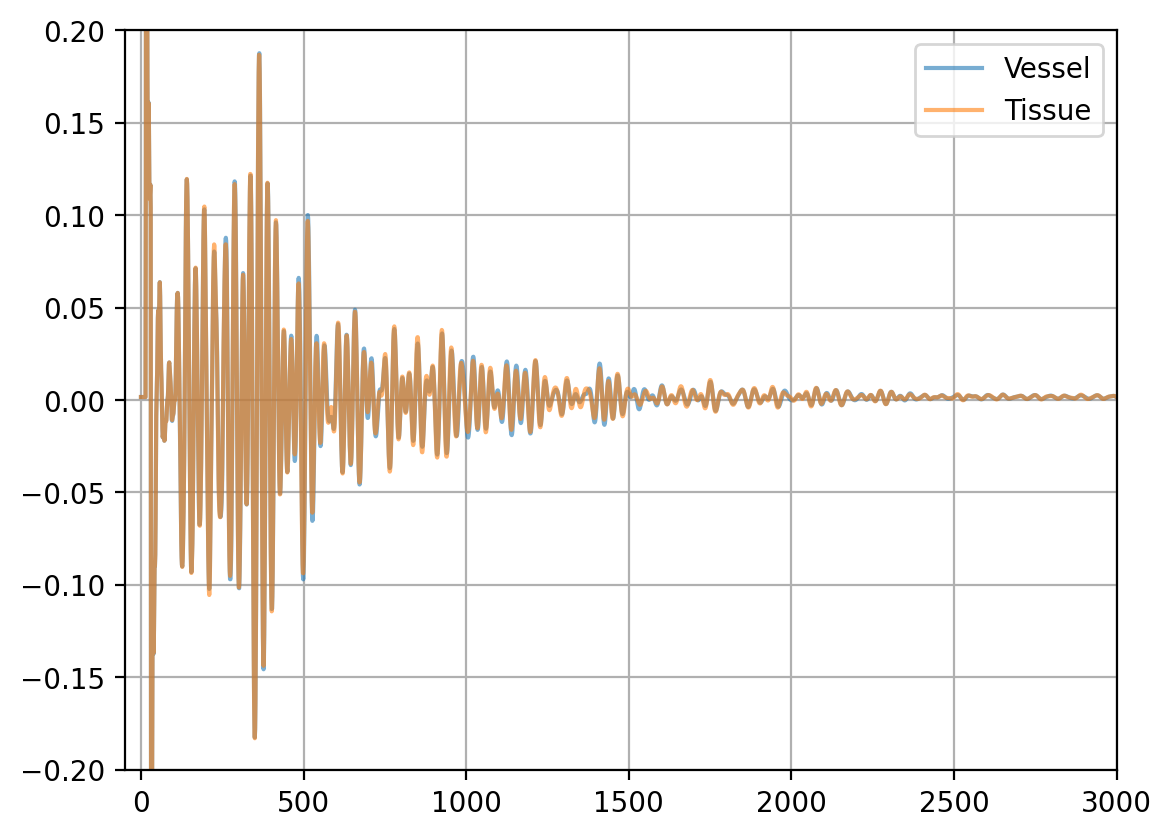

In [9]:
signalV = np.concatenate([datalist[i] for i in mater_idx["V"]],axis=0).mean(axis=0)
signalT = np.concatenate([datalist[i] for i in mater_idx["T"]],axis=0).mean(axis=0)
plt.figure(dpi=200)
plt.plot(signalT,alpha=0.6,label=materials[0])
plt.plot(signalV,alpha=0.6,label=materials[1])
plt.ylim((-0.2,0.2))
plt.xlim((-50,3000))
plt.legend()
plt.grid(True)

In [10]:
snapshot = np.concatenate(datalist,axis=0).squeeze()[:,:2500]
snapshot_r = np.concatenate(data_test,axis=0).squeeze()[:,:2500]
print(snapshot.shape)
print(snapshot_r.shape)
print(len(depthlist))
print(len(depthtest))

(93683, 2500)
(46889, 2500)
1600
800


In [11]:
# Save
recalculate = False
savefolder = "mwtfiles"
savepathV = os.path.join(savefolder,"Third_mwt_V.npy")
savepathS = os.path.join(savefolder,"Third_mwt_S.npy")
if not os.path.exists(savepathV) or recalculate:
    _, S, Vt = np.linalg.svd(snapshot, full_matrices=False)
    V = Vt.T
    np.save(savepathS, S)
    np.save(savepathV, V)
else:
    S = np.load(savepathS)
    V = np.load(savepathV)

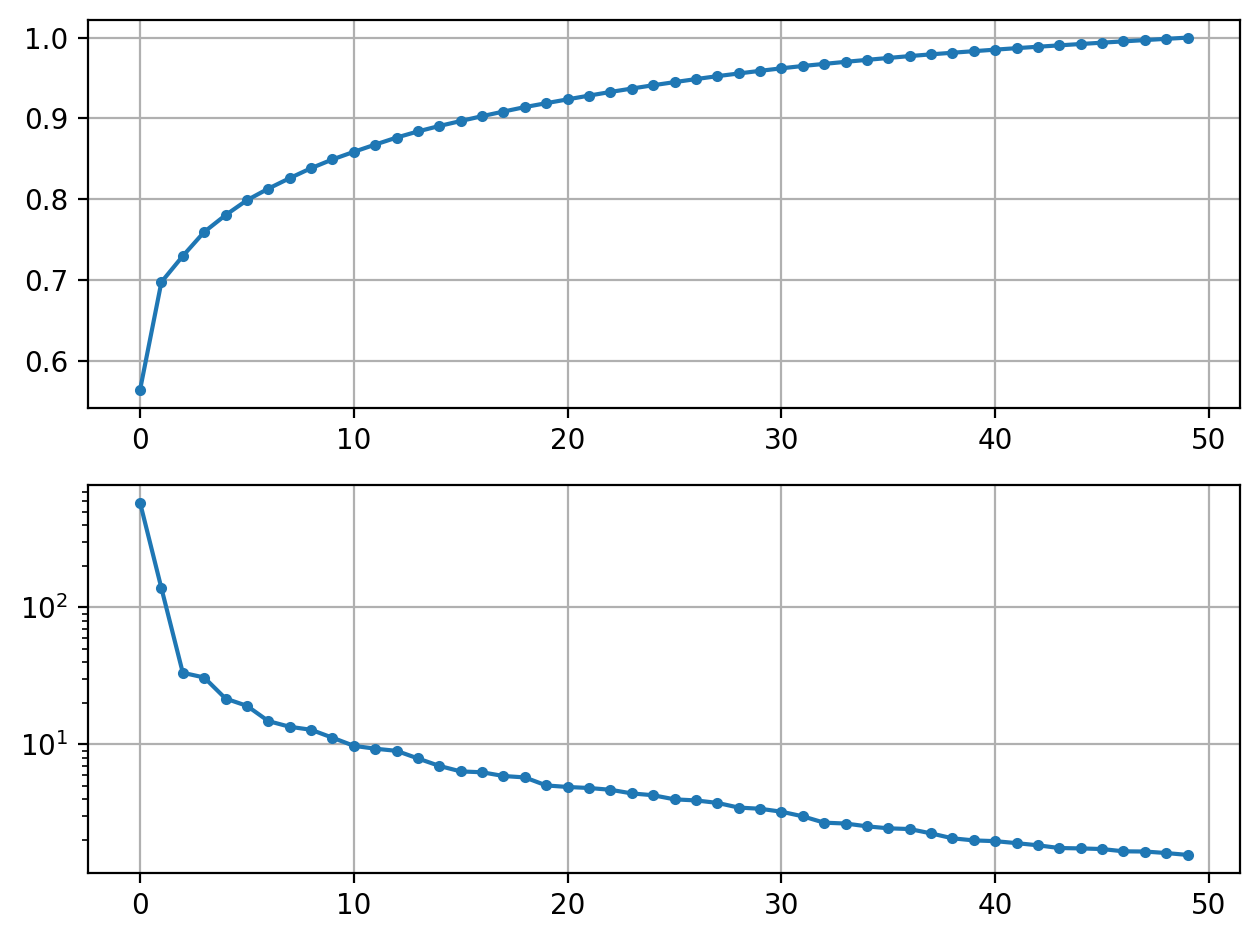

In [12]:
s = 50
energy = np.cumsum(S[:s])/np.sum(S[:s])
plt.figure(dpi=200)
plt.subplot(211)
plt.plot(energy,marker = 'o',linestyle='-',markersize = 3)
plt.grid(True)
plt.subplot(212)
plt.semilogy(S[:s],marker = 'o',linestyle='-',markersize = 3)
plt.grid(True)
plt.tight_layout()

In [13]:
r = 32
Vr = V[:,:r]
print(Vr.shape)

(2500, 32)


In [14]:
Xpp = snapshot @ Vr
X_rpp = snapshot_r @ Vr
print(Xpp.shape)
print(X_rpp.shape)

(93683, 32)
(46889, 32)


In [15]:
scaler = StandardScaler()

Xp = scaler.fit_transform(Xpp)
X_rp = scaler.transform(X_rpp)

In [16]:
def indices(shapelist):
    i = 0
    for shape in shapelist:
        yield list(range(i,i+shape))
        i = i+shape

In [17]:
channelist = []
channelist_r = []
for ind in indices(shapelist):
    data = Xp[ind]
    channelist.append(data)
for ind in indices(shape_test):
    data = X_rp[ind]
    channelist_r.append(data)
print(len(channelist))
print(len(channelist_r))
print(channelist[0].shape)

1600
800
(58, 32)


In [18]:
swlist = []
swlist_r = []
ylist = []
y_rlist = []
y_depth_list = []
y_r_depth_list = []
win = 20
for channel,label, depth in zip(channelist,labellist,depthlist):
    data = sliding_window_view(channel, axis=0, window_shape=win).transpose(0,2,1)
    depth_data = depth[win-1:]
    y = np.full(data.shape[0], label, dtype=int)
    swlist.append(data)
    ylist.append(y)
    y_depth_list.append(depth_data)
for channel,label, depth in zip(channelist_r,label_test,depthtest):
    data = sliding_window_view(channel, axis=0, window_shape=win).transpose(0,2,1)
    depth_data = depth[win-1:]
    y = np.full(data.shape[0], label, dtype=int)
    swlist_r.append(data)
    y_rlist.append(y)
    y_r_depth_list.append(depth_data)

X = np.concatenate(swlist, axis=0)
X_r = np.concatenate(swlist_r, axis=0)
y_class = np.concatenate(ylist)
y_r_class = np.concatenate(y_rlist)
y_depth = np.concatenate(y_depth_list)
y_r_depth = np.concatenate(y_r_depth_list)
y = np.stack((y_class,y_depth),axis=1)
y_r = np.stack((y_r_class,y_r_depth),axis=1)
print(X.shape)
print(X_r.shape)
print(y_class.shape)
print(y_r_class.shape)
print(y_depth.shape)
print(y_r_depth.shape)
print(y.shape)
print(y_r.shape)

(63283, 20, 32)
(31689, 20, 32)
(63283,)
(31689,)
(63283,)
(31689,)
(63283, 2)
(31689, 2)


(63283, 32)


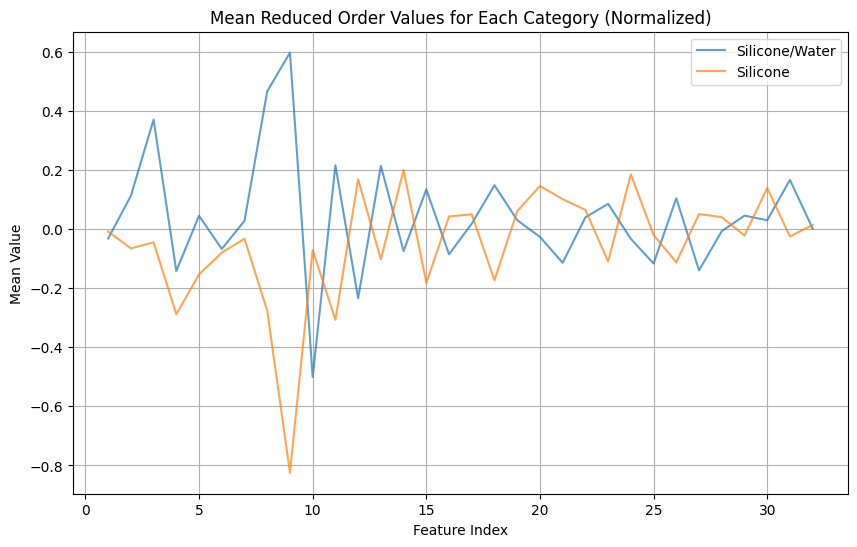

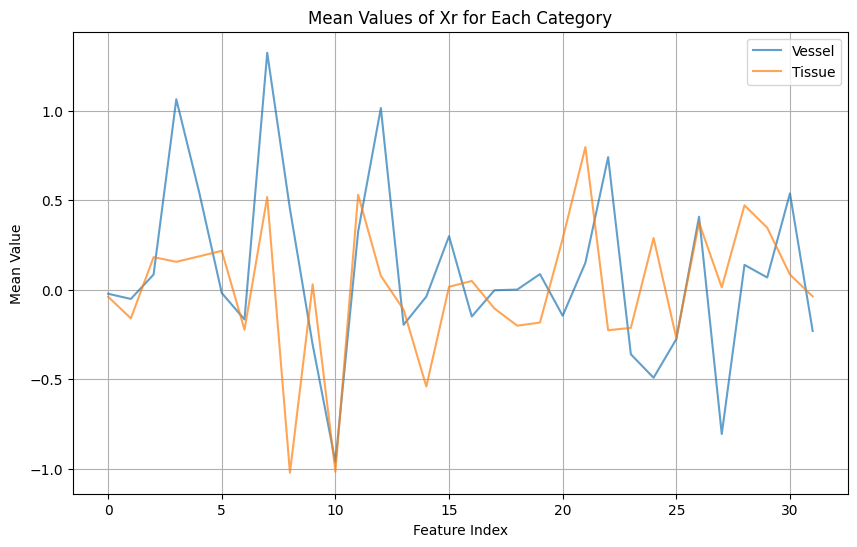

In [19]:
indices1 = {}
indices2 = {}
unique_labels = np.unique(y_class)
length = 2000
Xprint = np.concatenate((X[:length,-1,:],X[length:,-1,:]),axis=0)
X_rprint = np.concatenate((X_r[:length,-1,:],X_r[length:,-1,:]),axis=0)
print(Xprint.shape)
yb = np.concatenate((y_class[:length],y_class[length:]))
y_rb = np.concatenate((y_r_class[:length],y_r_class[length:]))
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(yb.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = Xprint[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(range(1, mean_values.shape[0] + 1), mean_values, label=f"{realmater[int(label)]}", alpha=0.7)
plt.xlabel("Feature Index")
# plt.xlim([1,36])
plt.ylabel("Mean Value")
plt.title("Mean Reduced Order Values for Each Category (Normalized)")
plt.legend()
plt.grid(True)

plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_rb.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_rprint[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[i]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)



In [20]:
X_ver,X_te,y_ver,y_te = train_test_split(X_r, y_r, test_size=0.5,shuffle=True)
print(X_ver.shape)
print(y_ver.shape)

(15844, 20, 32)
(15844, 2)


In [21]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [22]:
class TinyClassifier(nn.Module):
    def __init__(self, vec_dim=64, num_heads=4, num_classes=2, dropout = 0.001, attn_dropout=0.001):
        super().__init__()
        self.attn = BIMHSAttention(vec_dim, num_heads, attn_dropout=attn_dropout, proj_dropout=0,backend="math")
        self.ln = nn.LayerNorm(vec_dim)
        self.classifier = nn.Sequential(
            nn.Linear(vec_dim,14),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(14,num_classes)
        )
        self.regression = nn.Sequential(
            nn.Linear(vec_dim+num_classes,18),
            # nn.Linear(vec_dim,12),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(18,1)
        )
        # MLP([vec_dim,24,num_classes], actfunc='GELU')

    def forward(self,x):  # token_ids: (B, T)
        x = self.attn(x)                   # (B, C)  q/k/v are produced & used here
        x = self.ln(x)

        logits = self.classifier(x)               # (B, num_classes)
        added = torch.cat((logits,x),dim=1)
        depth = self.regression(added).squeeze(-1)
        return logits, depth

In [23]:
X_train_tensor = torch.tensor(X, dtype=torch.float32).to(device)
cls_y_train_tensor = torch.tensor(y[:,0], dtype=torch.long).squeeze().to(device)
reg_y_train_tensor = torch.tensor(y[:,1], dtype=torch.float32).squeeze().to(device)

X_ver_tensor = torch.tensor(X_ver, dtype=torch.float32).to(device)
cls_y_ver_tensor = torch.tensor(y_ver[:,0], dtype=torch.long).squeeze().to(device)
reg_y_ver_tensor = torch.tensor(y_ver[:,1], dtype=torch.float32).squeeze().to(device)

X_te_tensor = torch.tensor(X_te, dtype=torch.float32).to(device)
cls_y_te_tensor = torch.tensor(y_te[:,0], dtype=torch.long).squeeze().to(device)
reg_y_te_tensor = torch.tensor(y_te[:,1], dtype=torch.float32).squeeze().to(device)


idx = torch.randperm(X_train_tensor.size(0))  # 随机打乱索引
X_train_tensor = X_train_tensor[idx]
cls_y_train_tensor = cls_y_train_tensor[idx]
reg_y_train_tensor = reg_y_train_tensor[idx]
print(X_train_tensor.shape)
print(cls_y_train_tensor.shape)
print(X_te_tensor.shape)
print(reg_y_te_tensor.shape)

torch.Size([63283, 20, 32])
torch.Size([63283])
torch.Size([15845, 20, 32])
torch.Size([15845])


In [24]:
print(y[0])
print(cls_y_train_tensor[0])
print(reg_y_train_tensor[1])

[0 1]
tensor(0, device='cuda:0')
tensor(4., device='cuda:0')


In [25]:
seed = 42
set_seed(seed)
numhead = 2
dropout = 0.001
model = TinyClassifier(X.shape[-1],num_classes=2,num_heads=numhead,dropout=dropout, attn_dropout=0.0001).to(device)
# class_weights,_ = rebalance_weight(y[:,0])
classif_cri = nn.CrossEntropyLoss() #weight=class_weights.to(device)
learning_rate = 2e-5
cls_optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [26]:
train_losses = []
verify_losses = []
num_epochs=5014
pbar = tqdm(range(int(num_epochs)), desc="Training", leave=True)

for epoch in pbar:
    model.train()
    logits, _ = model(X_train_tensor)      # 解包更清晰
    loss = classif_cri(logits, cls_y_train_tensor)              # 分类
    loss.backward()
    cls_optimizer.step()
    cls_optimizer.zero_grad()    
    train_losses.append(loss.item())
    # —— 2. 验证 —— #
    model.eval()
    with torch.no_grad():
        verify_logits, _ = model(X_ver_tensor)
        verify_claloss = classif_cri(verify_logits, cls_y_ver_tensor)
        cla = verify_claloss.item()
        verify_losses.append(cla)

    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(
        train_loss = loss.item(),
        class_loss = cla
    )

Training:   0%|          | 0/5014 [00:00<?, ?it/s]

In [27]:
# Evaluate the model
model.eval()
with torch.no_grad():
    te_logits, te_depth = model(X_te_tensor)
    tr_logits, tr_depth = model(X_train_tensor)

    # 预测类别（按类别维度 argmax）
    _, predicted       = torch.max(te_logits, 1)
    _, predicted_train = torch.max(tr_logits, 1)

    # 转成 numpy
    predicted_np       = predicted.cpu().numpy()
    predicted_train_np = predicted_train.cpu().numpy()

    cls_y_train_np = cls_y_train_tensor.cpu().numpy()
    cls_y_te_np    = cls_y_te_tensor.cpu().numpy()  

    reg_y_train_np = reg_y_train_tensor.cpu().numpy()
    reg_y_te_np    = reg_y_te_tensor.cpu().numpy()  

    # 训练集准确率
    accuracy_train = accuracy_score(cls_y_train_np, predicted_train_np)
    # 测试集准确率 & 混淆矩阵
    accuracy = accuracy_score(cls_y_te_np, predicted_np)
    cm_train = confusion_matrix(cls_y_train_np, predicted_train_np)
    cm       = confusion_matrix(cls_y_te_np, predicted_np)


0.9994943349714773
0.9962133165036289


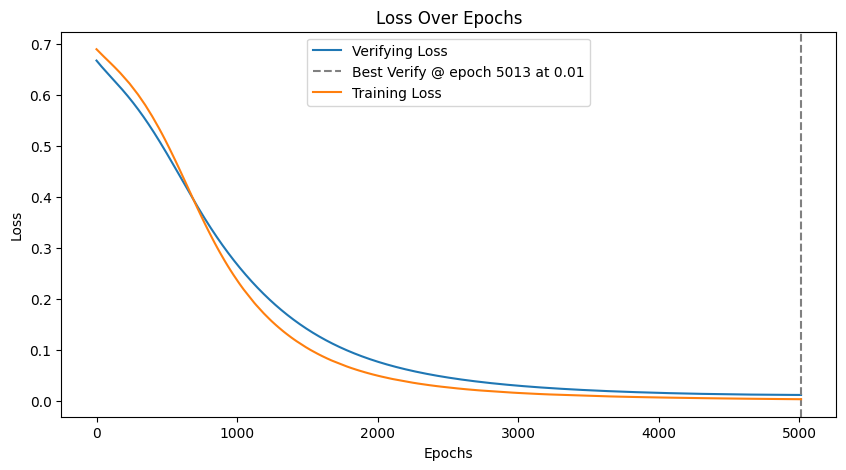

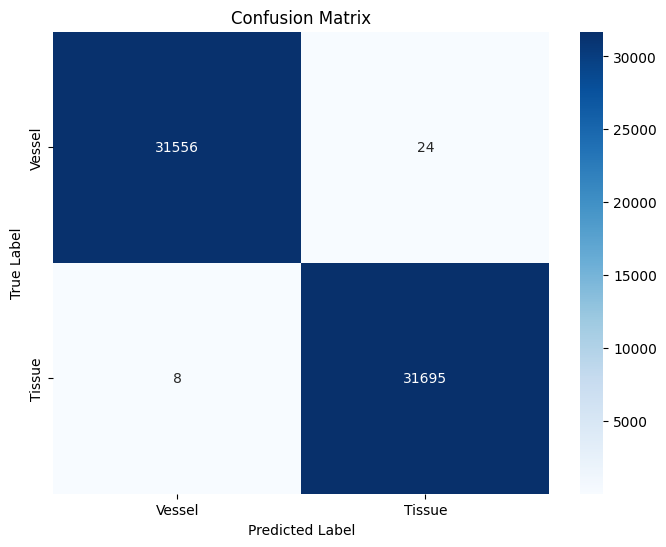

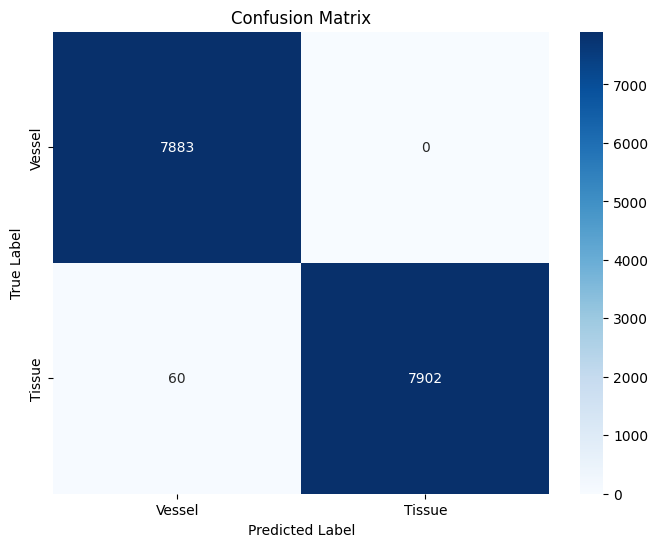

In [28]:
print(accuracy_train)
print(accuracy)
# cls_ver, *_ = zip(*verify_losses)
plt_loss(train_losses=train_losses,verifying_losses=verify_losses)
plt_confusion(cm_train, materials)
plt_confusion(cm, materials)

text = f"seedl = {seedl}, seed = {seed}, r = {r},  atthead = {numhead}, \
win = {win}, dropout = {dropout}, learning_rate = {learning_rate}, accuracy = {accuracy}\n"
with open("mwtfiles/Third_para.txt","a") as f:
    f.write(text)

In [30]:
def reset_regression_params(model):
    for m in model.regression.modules():
        if hasattr(m, "reset_parameters"):
            m.reset_parameters()

In [31]:
reset_regression_params(model)
regression_cri = nn.MSELoss()
re_learning_rate = 3e-4
reg_optimizer = optim.AdamW(model.regression.parameters(), lr=re_learning_rate)
model.classifier.requires_grad_(False)
model.attn.requires_grad_(False)
model.ln.requires_grad_(False)

LayerNorm((32,), eps=1e-05, elementwise_affine=True)

In [36]:
'''The Loss (loss.backward()): This calculates the gradients and stores them directly inside the parameter tensors 
(in the .grad attribute). It doesn't know about the optimizer.
The Optimizer (reg_optimizer.step()): This simply looks at the list of parameters you gave it. It checks if they 
have a .grad value waiting. If they do, it updates the parameter. It doesn't know how that gradient was calculated 
or what the loss was.'''

re_train_losses = []
re_verify_losses = []
reg_num_epochs = 10000
pbar = tqdm(range(int(reg_num_epochs)), desc="Training", leave=True)
for epoch in pbar:
    model.train()
    logits, depth = model(X_train_tensor)      # 解包更清晰 logits contains computational gragh
    loss = regression_cri(depth, reg_y_train_tensor) # 回归 loss contains computational gragh as well 
    loss.backward()
    reg_optimizer.step()
    reg_optimizer.zero_grad()
    re_train_losses.append(loss.item())
    # —— 2. 验证 —— #
    model.eval()
    with torch.no_grad():
        _, verify_depth = model(X_ver_tensor)
        verify_reloss  = regression_cri(verify_depth, reg_y_ver_tensor)
        dep = verify_reloss.item()
        re_verify_losses.append(dep)

    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(
        train_loss = loss.item(),
        rgs_loss   = dep
    )

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

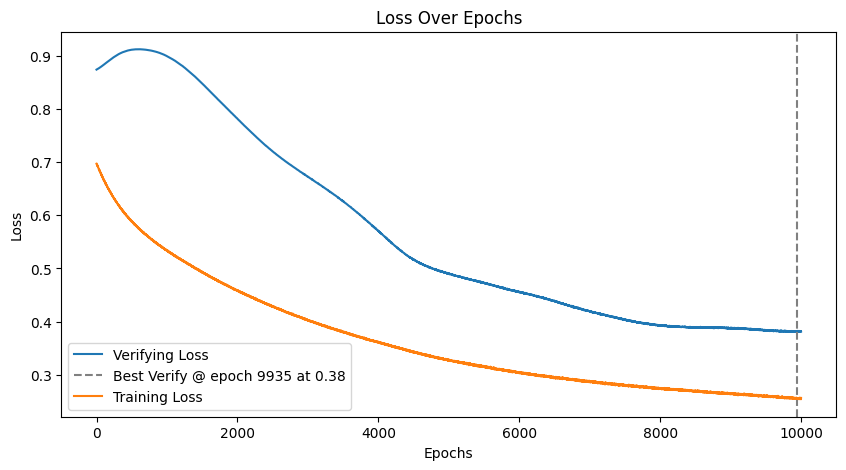

In [37]:
best_loss,_ = plt_loss(train_losses=re_train_losses,verifying_losses=re_verify_losses)

In [38]:
# Evaluate the model
model.eval()
with torch.no_grad():
    te_logits, te_depth = model(X_te_tensor)
    tr_logits, tr_depth = model(X_train_tensor)
    reg_y_train_np = reg_y_train_tensor.cpu().numpy()
    reg_y_te_np    = reg_y_te_tensor.cpu().numpy()  

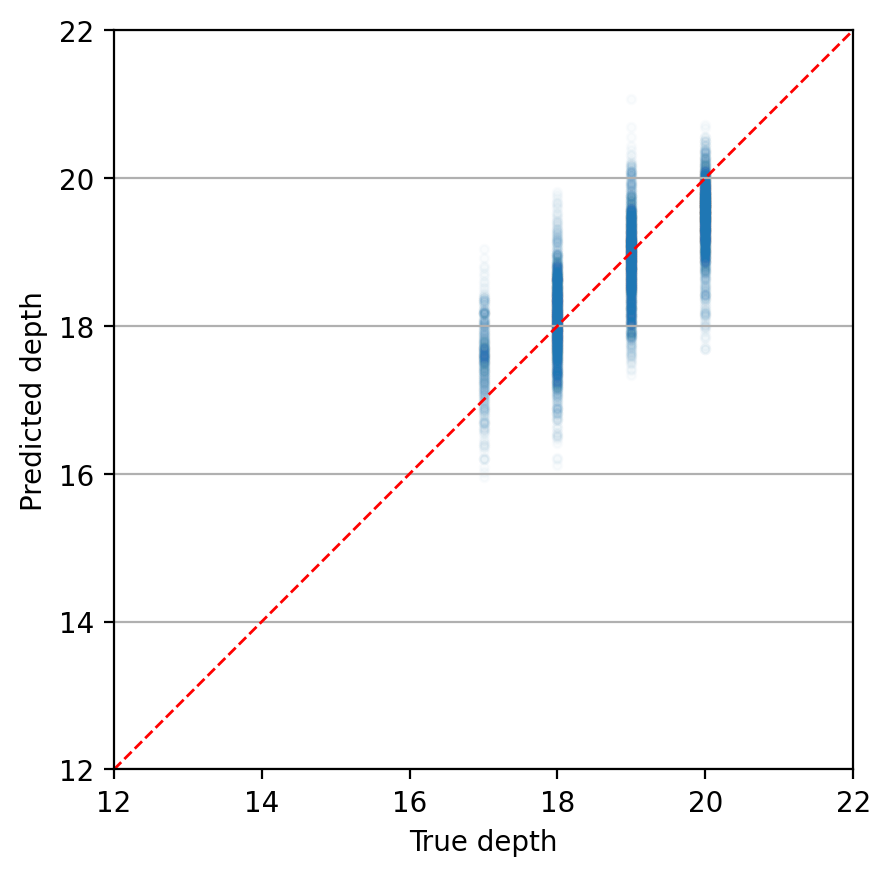

In [39]:
te_depth_np = te_depth.cpu().numpy()
# tr_depth_np = tr_depth.cpu().numpy()
num = 5000

out_dep_np, reg_np = te_depth_np[:num] + 16, reg_y_te_np[:num] + 16

plt.figure(dpi=200)
plt.scatter(reg_np, out_dep_np, s=10, alpha=0.02)

min_val = 12
max_val = 22
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlim((min_val, max_val))
plt.ylim((min_val, max_val))

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')   # 只改比例，不重算 limits

plt.xlabel("True depth")
plt.ylabel("Predicted depth")
plt.grid(axis='y')
plt.show()


In [40]:
text = f"REGRESSION: seedl = {seedl}, seed = {seed}, r = {r},  atthead = {numhead}, \
win = {win}, dropout = {dropout}, learning_rate = {learning_rate}, best_verify_loss = {best_loss}\n"
with open("mwtfiles/Third_para.txt","a") as f:
    f.write(text)

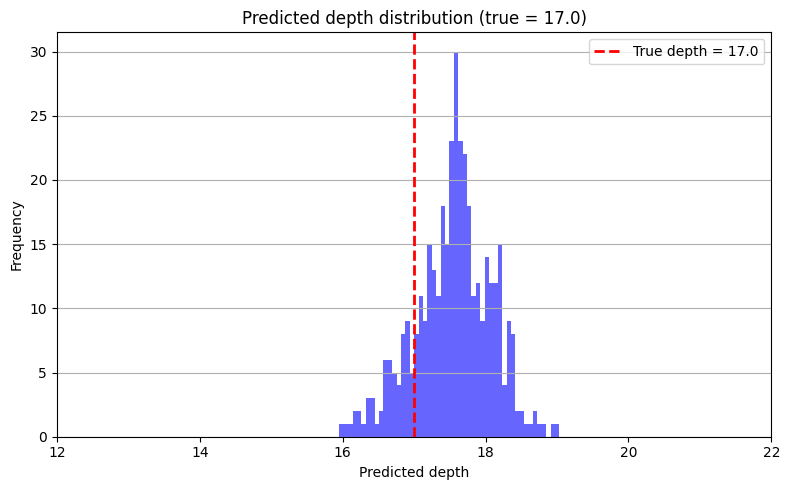

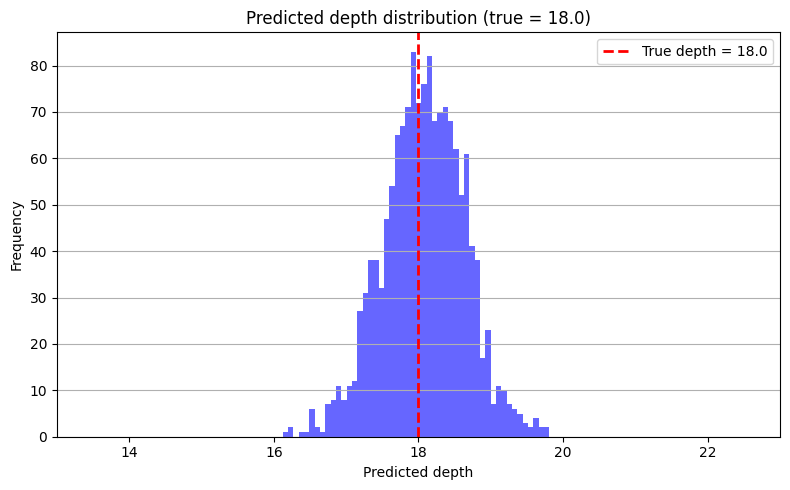

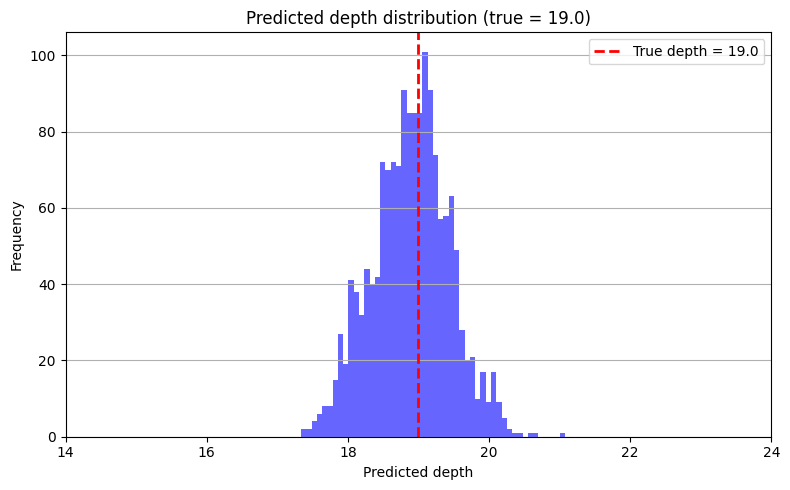

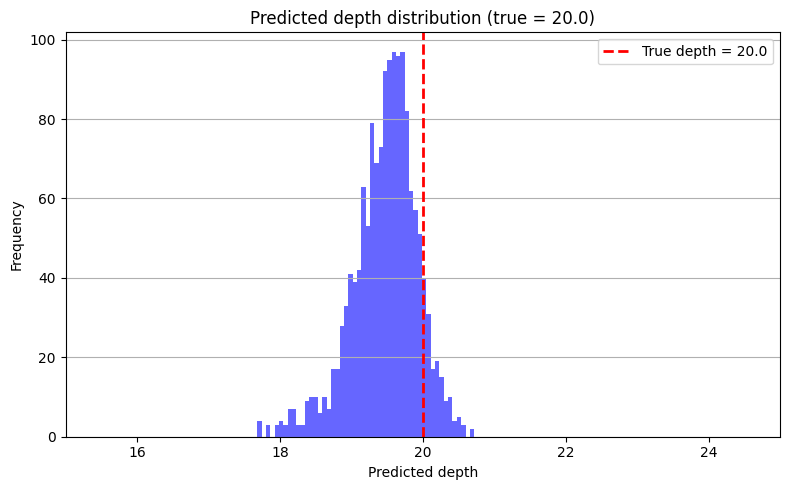

In [41]:
labels = np.unique(reg_np)
mask   = labels[:, None] == reg_np[None, :]   # (K, N)

for lab, ma in zip(labels, mask):
    plt.figure(figsize=(8, 5))
    # 该真实标签下的预测深度
    vals = out_dep_np[ma]

    plt.hist(vals, bins=50, color='blue', alpha=0.6)

    # 画一条真实深度的竖直线
    plt.axvline(lab, color='red', linestyle='--', linewidth=2,
                label=f"True depth = {lab}")

    # 让真实标签大致居中（可按需要调 delta）
    delta = 5  # 比如左右各 2 单位
    plt.xlim(lab - delta, lab + delta)

    plt.xlabel("Predicted depth")
    plt.ylabel("Frequency")
    plt.title(f"Predicted depth distribution (true = {lab})")
    plt.grid(True, axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()


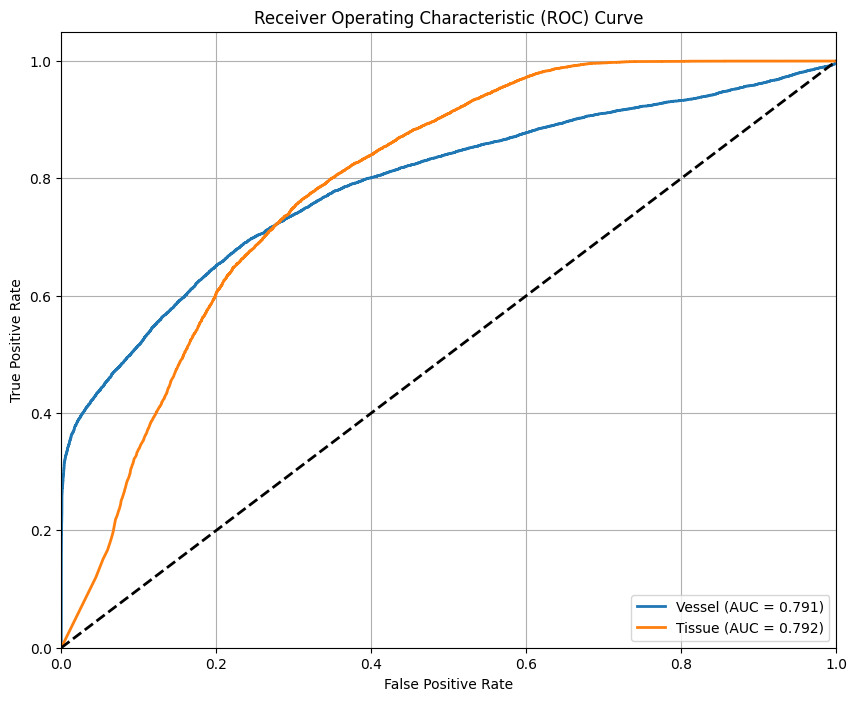

In [ ]:
model.eval()
with torch.no_grad():
    logits, _ = model(X_te_tensor.to(device))    # [N,2]
    # 方法 A：用 softmax 概率
    probs = torch.softmax(logits, dim=1)           # [N, 2]
# One-vs-rest approach for ROC curves
n_classes = len(materials)  
fpr = {}
tpr = {}
roc_auc = {}

# Get prediction probabilities for each class
probs_np = probs.cpu().numpy()

# Calculate ROC curve and ROC area for each class
for i, class_name in enumerate(materials):
	# Convert to binary classification: current class vs rest
	y_binary = (cls_y_te_np.flatten() == i).astype(int)
	fpr[class_name], tpr[class_name], _ = roc_curve(y_binary, probs_np[:, i])
	roc_auc[class_name] = roc_auc_score(y_binary, probs_np[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for class_name in materials:
	plt.plot(fpr[class_name], tpr[class_name], lw=2,
			 label=f'{class_name} (AUC = {roc_auc[class_name]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()